In [31]:
!uv add matplotlib
!uv add numpy
!uv add tensorflow
!uv add scipy

Resolved 48 packages in 15ms
Uninstalled 1 package in 7ms
Installed 1 package in 4ms                                  
 ~ grpcio==1.69.0
Resolved 48 packages in 4ms
Uninstalled 1 package in 5ms
Installed 1 package in 2ms                                  
 ~ grpcio==1.69.0
Resolved 48 packages in 4ms
Uninstalled 1 package in 4ms
Installed 1 package in 2ms                                  
 ~ grpcio==1.69.0
Resolved 50 packages in 540ms                                        
Uninstalled 1 package in 4ms                                         
Installed 2 packages in 50ms                                
 ~ grpcio==1.69.0
 + scipy==1.15.3


In [2]:
from tensorflow.keras import datasets
from tensorflow.keras import layers, models, optimizers
import numpy as np
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

def preprocess(imgs):
    imgs = imgs.astype('float32') / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, axis=-1)
    return imgs

x_train = preprocess(x_train)
x_test = preprocess(x_test)

# 定义编码器的Input 层（图像）
encoder_input = layers.Input(shape=(32, 32, 1), name = "encoder_input")
# 将Conv2D 层顺序堆叠在一起
x = layers.Conv2D(32, (3, 3), strides = 2, activation = 'relu', padding = 'same')(encoder_input)
x = layers.Conv2D(64, (3, 3), strides = 2, activation = 'relu', padding = 'same')(x)
x = layers.Conv2D(128, (3, 3), strides = 2, activation = 'relu', padding = 'same')(x)

# 通过切片操作，跳过第一个维度（批次维度），只保留后面的维度
shape_before_flattening = x.shape[1:]

# 将最后一个卷积层展平为向量
x = layers.Flatten()(x)
# 通过 Dense 层将该向量连接到二维嵌入
encoder_output = layers.Dense(2, name = "encoder_output")(x)
# 定义编码器的 Keras Model — 该模型接收输入图像并将其编码为二维嵌入
encoder = models.Model(encoder_input, encoder_output)

print(encoder.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,770 (378.01 KB)

 Trainable params: 96,770 (378.01 KB)

 Non-trainable params: 0 (0.00 B)

None


In [3]:
# 定义解码器的 Input 层（嵌入层）
decoder_input = layers.Input(shape=(2,), name = "decoder_input")
# 将输入连接到 Dense 层
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
# Reshape 将该向量转换为可馈入第一个 Conv2DTranspose 层的张量
x = layers.Reshape(shape_before_flattening)(x)

# 将 Conv2DTranspose 层堆叠在一起
x = layers.Conv2DTranspose(128, (3, 3), strides = 2, activation = 'relu', padding = 'same')(x)
x = layers.Conv2DTranspose(64, (3, 3), strides = 2, activation = 'relu', padding = 'same')(x)
x = layers.Conv2DTranspose(32, (3, 3), strides = 2, activation = 'relu', padding = 'same')(x)

decoder_output = layers.Conv2D(
    1,
    (3, 3),
    strides = 1,
    activation = 'sigmoid',
    padding = 'same',
    name = "decoder_output"
)(x)

# Keras Model 定义了解码器, 一个接收潜在空间嵌入并将其解码回原始图像域的模型
decoder = models.Model(decoder_input, decoder_output)

print(decoder.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Conv2D)         │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# 定义完整自编码器的 Keras Model ——该模型接收一幅图像,
# 通过编码器处理后再经解码器输出，以生成原始图像的重建结果
autoencoder = models.Model(encoder_input, decoder(encoder_output))
# 编译自编码器
autoencoder.compile(optimizer = optimizers.Adam(), loss = 'binary_crossentropy')

# 将输入图像同时作为输入和输出来训练自编码器
autoencoder.fit(
    x_train,
    x_train,
    epochs = 5,
    batch_size = 128,
    shuffle=True,
    validation_data = (x_test, x_test)
)

In [ ]:
# 使用自编码器重建图像
example_images = x_test[:500]
predictions = autoencoder.predict(example_images)

# 使用编码器嵌入图像
embeddings = encoder.predict(example_images)

plt.figure(figsize = (8, 8))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=3)
plt.show()

In [ ]:
# 使用解码器生成新图像
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)
sample = np.random.uniform(mins, maxs, size=(18, 2))
reconstructions = decoder.predict(sample)

plt.figure(figsize = (8, 8))
plt.scatter(reconstructions[:, 0], reconstructions[:, 1], c="blue", alpha=0.5, s=3)
plt.show()

In [4]:
import tensorflow as tf

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [6]:
# 编码器
encoder_input = layers.Input(shape=(32, 32, 1), name="encoder_input")
x = layers.Conv2D(32, (3, 3), strides=2, activation='relu', padding='same')(encoder_input)
x = layers.Conv2D(64, (3, 3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation='relu', padding='same')(x)

shape_before_flattening = x.shape[1:]
x = layers.Flatten()(x)
z_mean = layers.Dense(2, name="z_mean")(x)
z_log_var = layers.Dense(2, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
print(encoder.summary())

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │        320 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 8, 8, 64)  │     18,496 │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 4, 4, 128) │     73,856 │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 2048)      │          0 │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │      4,098 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │      4,098 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_1          │ (None, 2)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 100,868 (394.02 KB)

 Trainable params: 100,868 (394.02 KB)

 Non-trainable params: 0 (0.00 B)

None


In [19]:
from tensorflow.keras import losses

# 训练变分自编码器
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
            
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                500 * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)), axis=1)
            )

            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return { m.name: m.result() for m in self.metrics }
    
    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            500
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }    

# create a variational autoencoder
vae = VAE(encoder, decoder)

# train the variational autoencoder
vae.compile(optimizer=optimizers.Adam(learning_rate=0.0005))
vae.fit(
    x_train,
    epochs=5,
    batch_size=128,
    shuffle=True,
    validation_data = (x_test, x_test)
)

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 32s 67ms/step - kl_loss: 5.4598 - reconstruction_loss: 123.8872 - total_loss: 129.3470 - val_kl_loss: 5.5101 - val_loss: 122.7469 - val_reconstruction_loss: 117.2368
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 31s 66ms/step - kl_loss: 5.4717 - reconstruction_loss: 123.2306 - total_loss: 128.7023 - val_kl_loss: 5.6263 - val_loss: 125.2883 - val_reconstruction_loss: 119.6620
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 31s 67ms/step - kl_loss: 5.4856 - reconstruction_loss: 123.2462 - total_loss: 128.7318 - val_kl_loss: 5.5547 - val_loss: 124.8461 - val_reconstruction_loss: 119.2913
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 30s 64ms/step - kl_loss: 5.4812 - reconstruction_loss: 123.3635 - total_loss: 128.8448 - val_kl_loss: 5.7151 - val_loss: 124.1202 - val_reconstruction_loss: 118.4051
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 30s 65ms/step - kl_loss: 5.5044 - reconstruction_loss: 123.2153 - total_loss: 128.7197 - val_kl_loss: 5.5432 - val_loss: 124.2531 - val_recon

In [20]:
# Select a subset of the test set
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Example real clothing items


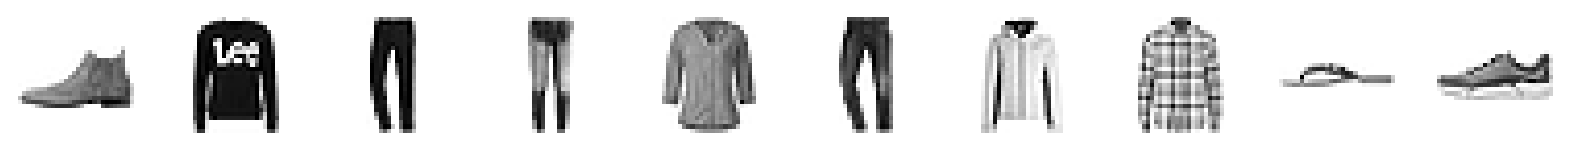

Reconstructions


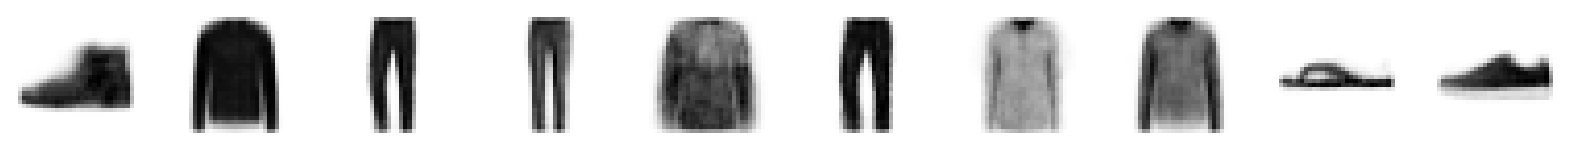

In [22]:
from utils import display

# Create autoencoder predictions and display
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Example real clothing items")
display(example_images)
print("Reconstructions")
display(reconstructions)

# 4. Embed using the encoding

In [26]:
# Encode the example images
z_mean, z_var, z = encoder.predict(example_images)

# Some examples of the embeddings
print(z[:10])

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[[-0.43054008 -1.0212429 ]
 [ 1.1379666   0.20716769]
 [ 0.7369936   2.2322872 ]
 [-0.71256346  1.8839604 ]
 [-0.10001814 -0.06443338]
 [ 1.7561444   2.1399567 ]
 [-1.5638963   0.2514299 ]
 [-0.22485754  0.10076515]
 [-1.7598426  -2.8432052 ]
 [ 0.41731817 -2.214041  ]]


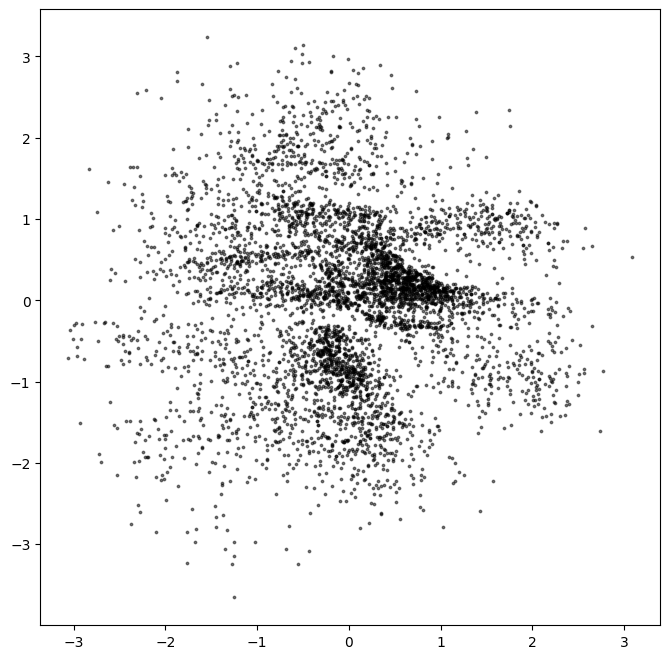

In [27]:
# show the encoded points in 2D space
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black",  alpha=0.5, s=3)
plt.show()

# 5. Generate using the decoder

In [28]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))


In [29]:
# decode the sampled points
reconstructions = decoder.predict(z_sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


In [32]:
from scipy.stats import norm

# convert original embeddings and sampled embeddings to p-values
p = norm.cdf(z)
p_sample = norm.cdf(z_sample)

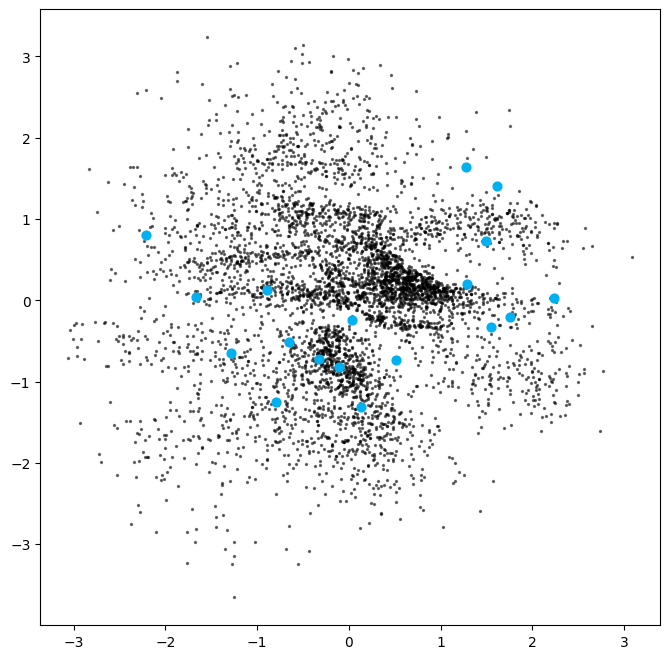

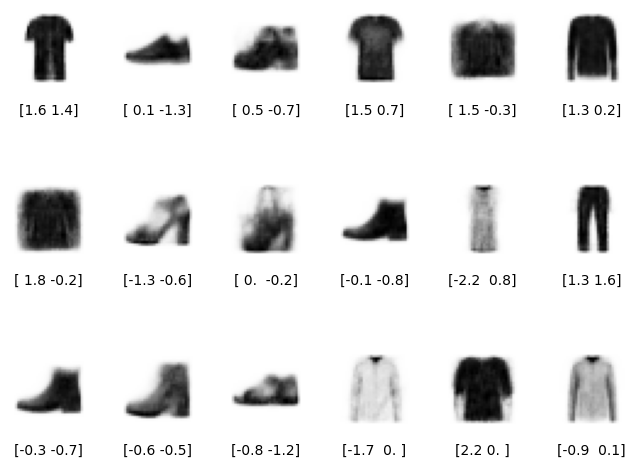

In [33]:
# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

# 6. Explore the latent space

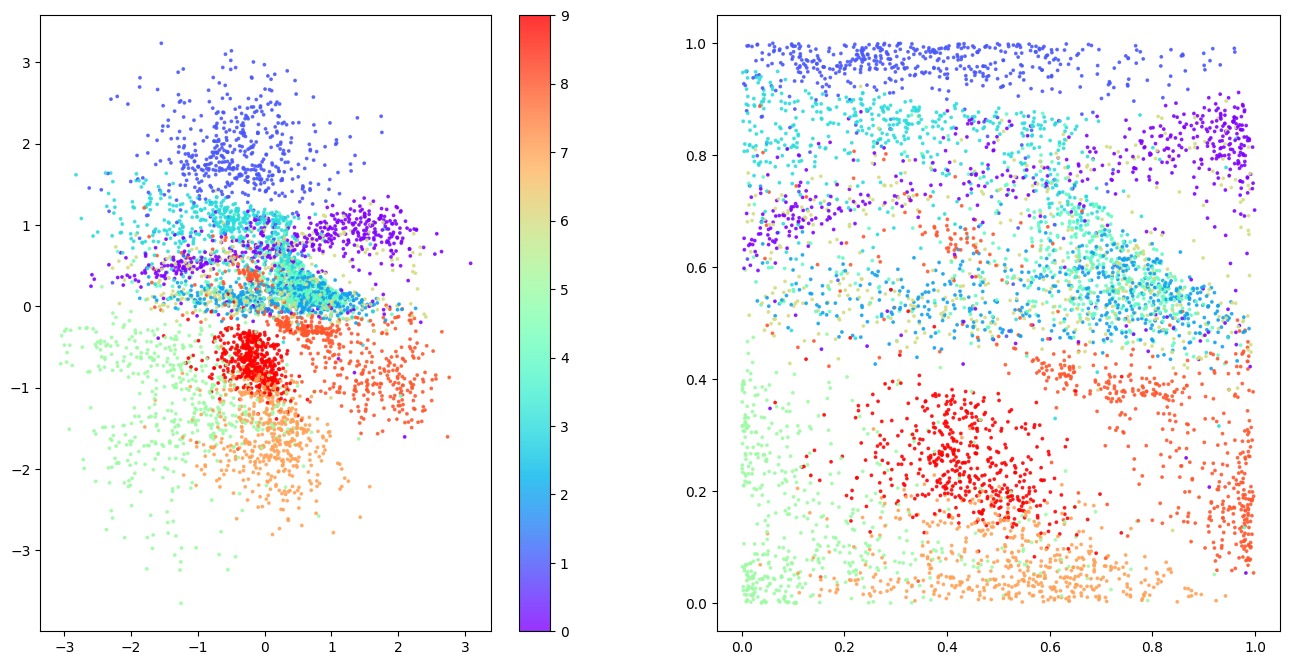

In [34]:
# colour the embeddings by their label (clothing type - see table)
figsize = 8
fig = plt.figure(figsize=(figsize * 2, figsize))
ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(z[:, 0], z[:, 1], cmap='rainbow', c=example_labels, alpha=0.8, s=3)
plt.colorbar(plot_1)
ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(p[:, 0], p[:, 1], cmap='rainbow', c=example_labels, alpha=0.8, s=3)
plt.show()

ID	Clothing Label
0	T-shirt/top
1	Trouser
2	Pullover
3	Dress
4	Coat
5	Sandal
6	Shirt
7	Sneaker
8	Bag
9	Ankle boot

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


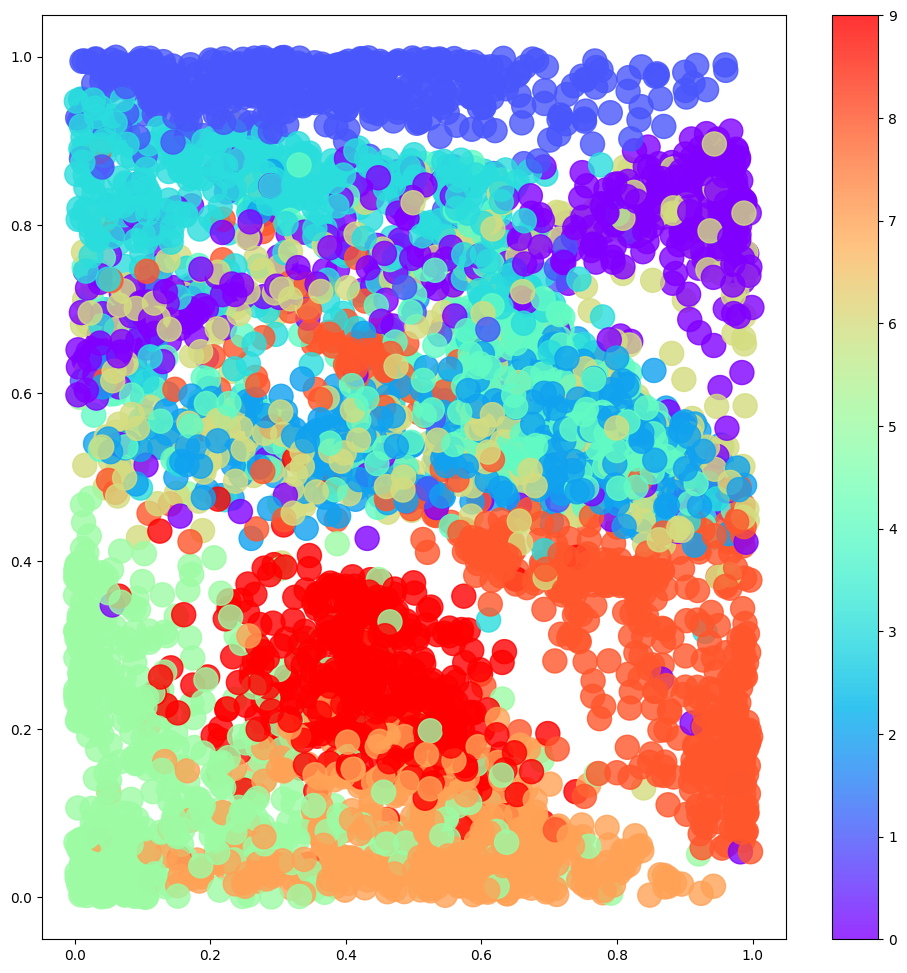

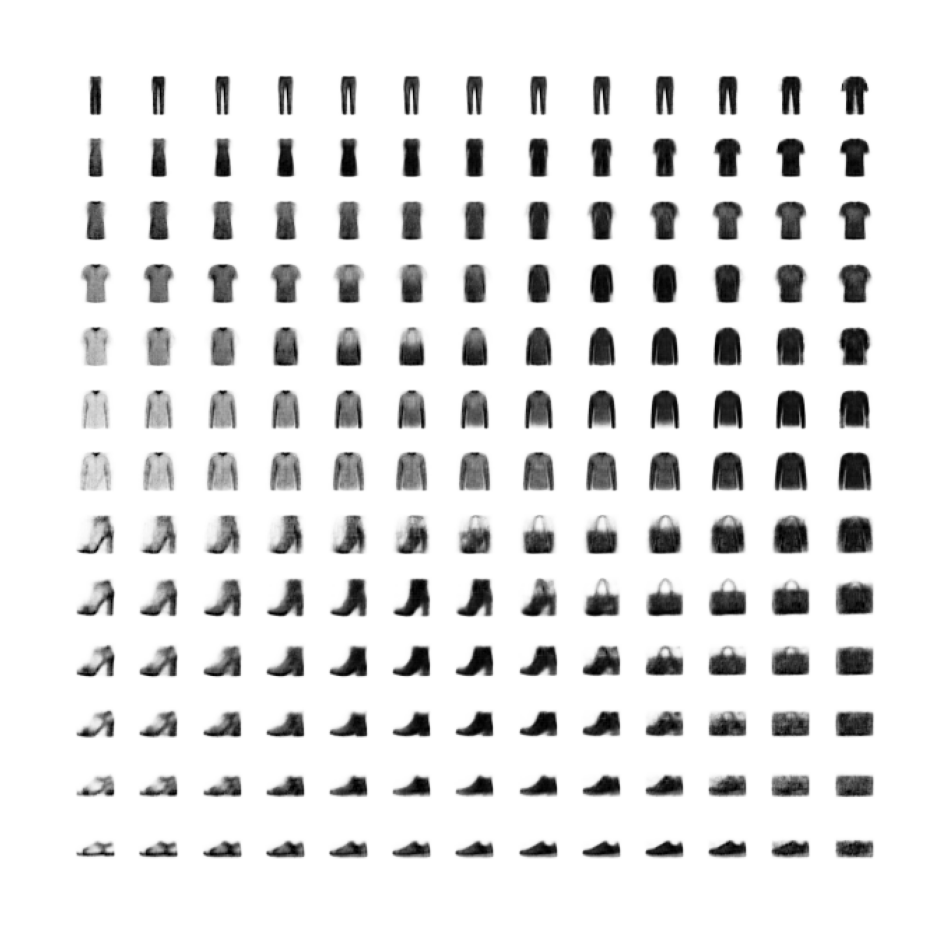

In [35]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=300
)
plt.colorbar()

x = norm.ppf(np.linspace(0, 1, grid_size))
y = norm.ppf(np.linspace(1, 0, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")